In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from tqdm import tqdm
from monai.data import CacheDataset, Dataset, list_data_collate
from monai.transforms import (
    AsChannelFirstd,
    AddChanneld,
    AsDiscreted,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    RandRotated,
    RandZoomd,
    Rotated,
    ScaleIntensityd,
    ScaleIntensityRanged,
    ThresholdIntensityd,
    Transposed,
    EnsureTyped,
    RandAffined,
    Transform,
    MapTransform,
    RandGibbsNoised,
    RandKSpaceSpikeNoised,
    RandGaussianNoised,
    RandCoarseDropoutd,
    ResizeWithPadOrCropd,
    RandSpatialCropd,
    Lambdad
)

# ensure is in parent directory
try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

c:\Users\mo\Documents\Organisations\RUG\rug-hr\experiments
c:\Users\mo\Documents\Organisations\RUG\rug-hr


## Experiment setup

In [2]:
SPATIAL_SIZE = [128, 1024]
SPATIAL_ALIAS = "x".join([str(x) for x in SPATIAL_SIZE])
VERSION = "v3"
ALIAS = "iam"
MODEL_OUTPUT_NAME = f"seglm-masked-{VERSION}-{SPATIAL_ALIAS}-{ALIAS}.pt"

config = {
    "epochs": 200,
    "batch_size": 12,
    "learning_rate": 1e-4,
    "architecture": "UNETR",
    "dataset": "handwitten_manuscripts",
    "spatial_size": SPATIAL_SIZE,
    "splits": [0.88, 0.08],
    "model_output_name": MODEL_OUTPUT_NAME,
    "name": "IAM handwriting recognition",
    "description": "Masked language model for handwriting recognition",
    "pretrained_model": "seglm-masked-v1-128x1024-iam.pt",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

# print summary
print("Configuration:")
print("Output model name: ", config["model_output_name"])
print("Using model: ", config["architecture"])
print("Using dataset: ", config["dataset"])
print("Using spatial size: ", config["spatial_size"])
print("Using splits: ", config["splits"])
print("Using learning rate: ", config["learning_rate"])
print("Using batch size: ", config["batch_size"])
print("Using epochs: ", config["epochs"])
print("Using pretrained model: ", config["pretrained_model"])

Configuration:
Output model name:  seglm-masked-v3-128x1024-iam.pt
Using model:  UNETR
Using dataset:  handwitten_manuscripts
Using spatial size:  [128, 1024]
Using splits:  [0.88, 0.08]
Using learning rate:  0.0001
Using batch size:  12
Using epochs:  200
Using pretrained model:  seglm-masked-v1-128x1024-iam.pt


In [3]:
import wandb


def init_experiment(config=config):
    wandb.init(
        project="handwriting-recognition-iam",
        config=config,
    )


def terminate_experiment():
    wandb.finish()


def log(data):
    wandb.log(data)

## Data setup

Some notes:
- Max height: 342; Max width: 2260
- Min height: 44; Min width: 100
- Mean height: 121.56060606060606; Mean width: 1693.719093590775
- Max tokens: 27

In [4]:
dataset_name = config["dataset"]
segs = glob(f"./datasets/{dataset_name}/Raw/*")
imgs = glob(f"./datasets/{dataset_name}/Mutated/*")
fraction = 1

metadata = [{
    "img": p_img,
    "seg": p_seg,
} for p_img, p_seg in zip(imgs, segs)]

random.shuffle(metadata)
metadata = metadata[:int(len(metadata) * fraction)]

# split into training, validation and test set
split_train = int(len(metadata) * config["splits"][0])
split_validation = int(len(metadata) * (config["splits"][1] + config["splits"][0]))

train_metadata = metadata[:split_train]
validation_metadata = metadata[split_train:split_validation]
test_metadata = metadata[split_validation:]

print(
    f"Train: {len(train_metadata)}; Validation: {len(validation_metadata)}; Test: {len(test_metadata)}")
print(f"Example: {train_metadata[0]}")
n_classes = ord("~") - ord(" ") + 1
print(f"Number of classes: {n_classes}")

Train: 23254; Validation: 2114; Test: 1057
Example: {'img': './datasets/handwitten_manuscripts/Mutated\\41785_Alifiyah_29.png', 'seg': './datasets/handwitten_manuscripts/Raw\\41785_Alifiyah_29.png'}
Number of classes: 95


In [5]:

from monai.config import KeysCollection


class Invert(Transform):
    def __call__(self, data, max_value=1.0, min_value=0.0):
        return max_value - data + min_value


class Invertd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.invert = Invert()

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.invert(d[key])
        return d


class AddMask(Transform):
    """ Adds a mask channel to the image where 
    Args: 
        prob: probability of zeroing out a region
        min_portion: minimum portion of the image to zero out in each dimension
        max_portion: maximum portion of the image to zero out in each dimension
    """

    def __init__(self,
                 prob=0.5,
                 min_portion=(0.1, 0.1),
                 max_portion=(0.5, 0.5)):
        self.prob = prob
        self.min_portion = min_portion
        self.max_portion = max_portion

    """
    Args:
        image: (..., C, H, W)
    Returns: with mask channel added
        image: (..., C+1, H, W)
    """

    def __call__(self, image):
        C, H, W = image.shape[-3:]
        mask = torch.ones((*image.shape[:-3], 1, H, W))
        if random.random() < self.prob:
            min_p_i, min_p_j = self.min_portion
            max_p_i, max_p_j = self.max_portion
            p_i = random.uniform(min_p_i, max_p_i)
            p_j = random.uniform(min_p_j, max_p_j)
            size_i = int(H * p_i)
            size_j = int(W * p_j)
            i_start = random.randint(0, H - size_i)
            j_start = random.randint(0, W - size_j)
            i_end = i_start + size_i
            j_end = j_start + size_j
            mask[..., i_start:i_end, j_start:j_end] = 0
        image *= mask
        return torch.cat([image, mask], dim=-3)


class AddMaskd(MapTransform):
    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False, *argc,
                 **argv) -> None:
        super().__init__(keys, allow_missing_keys)
        self.add_mask = AddMask(*argc, **argv)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = self.add_mask(d[key])
        return d


augmentation_transforms = Compose([
    RandCoarseDropoutd(keys=["img"], holes=128, spatial_size=(8, 8), max_holes=128, fill_value=0,
                       prob=0.5),
    RandGaussianNoised(keys=["img"], mean=0.0, std=0.02, prob=0.7),
    RandShiftIntensityd(keys=["img"], offsets=0.1, prob=0.5),
])

input_transforms = Compose([
    # Image transformations
    LoadImaged(keys=["img", "seg"]),
    AddChanneld(keys=["img", "seg"]),
    EnsureTyped(keys=["img", "seg"]),
    Transposed(keys=["img", "seg"], indices=[0, -1, -2]),
    CropForegroundd(keys=["img", "seg"], source_key="img", ),
    ResizeWithPadOrCropd(
        keys=["img", "seg"],
        spatial_size=(256, 2048),
        mode="constant",
    ),
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    # Augmentation
    augmentation_transforms,
    # Post processing
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=1, b_min=0.0, b_max=1.0, clip=True),
    AddMaskd(
        keys=["img"],
        prob=1.0,
        min_portion=(0.8, 0.01),
        max_portion=(0.9, 0.05),
    ),
    RandSpatialCropd(
        keys=["img", "seg"],
        roi_size=config["spatial_size"],
        random_size=False,
    ),
    Lambdad(keys=["seg"], func=lambda x: torch.clamp(x, 0, n_classes - 1)),
    EnsureTyped(keys=["img", "seg"]),
])

train_transforms = Compose([
    input_transforms,
    EnsureTyped(keys=["img", "seg"]),
])

validation_transforms = Compose([
    input_transforms,
    EnsureTyped(keys=["img", "seg"]),
])


c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


image: torch.Size([2, 128, 1024])
segmentation: torch.Size([1, 128, 1024])
range(img): (tensor(0.), tensor(1.))
range(img[1]): (tensor(1.), tensor(1.))
range(seg): (tensor(0.), tensor(89.))


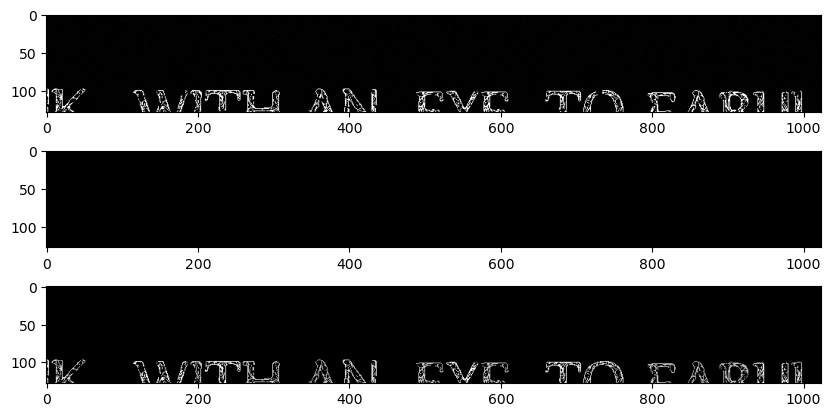

In [6]:

# example
choice = random.choice(train_metadata)
output = train_transforms(choice)
spatial_size = torch.zeros(config["spatial_size"]).shape
assert output["img"][0].shape == spatial_size or print(output["img"][0].shape, spatial_size)
assert output["seg"][0].shape == spatial_size or print(output["seg"][0].shape, spatial_size)
# ensuer seg is at max n_classes
assert output["seg"].max() < n_classes or print("wrong seg max", output["seg"].max())
assert output["seg"].min() >= 0 or print("wrong seg min", output["seg"].min())
assert output["img"].max() <= 1 or print("wrong img max", output["img"].max())
assert output["img"].min() >= 0 or print("wrong img min", output["img"].min())
assert output["img"].shape[0] == 2 or print(output["img"].shape)
assert output["seg"].shape[0] == 1 or print(output["seg"].shape)

print("image:", output["img"].shape)
print("segmentation:", output["seg"].shape)
print(f"range(img): ({output['img'].min()}, {output['img'].max()})")
print(f"range(img[1]): ({output['img'][1].min()}, {output['img'][1].max()})")
print(f"range(seg): ({output['seg'].min()}, {output['seg'].max()})")
fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].imshow(output["img"][0], cmap="gray")
ax[1].imshow(output["img"][1], cmap="gray")
ax[2].imshow(output["seg"][0], cmap="gray")
plt.show()

In [7]:
train_dataset = CacheDataset(data=train_metadata, transform=train_transforms)
validation_dataset = CacheDataset(data=validation_metadata, transform=validation_transforms)
test_dataset = Dataset(data=test_metadata, transform=input_transforms)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"])
validation_loader = DataLoader(validation_dataset, batch_size=config["batch_size"])
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])

Loading dataset: 100%|██████████| 2114/2114 [00:00<00:00, 2118699.80it/s]


### Reconstruction loss

The network failes to reconstruct, hence we add a term to the loss function that penalizes the network for not reconstructing the masked region.

In [8]:
from monai.losses import DiceCELoss


class RCLoss(torch.nn.Module):

    def __init__(self, dice_weight=0.2, weight=None, size_average=True):
        super(RCLoss, self).__init__()
        self.dice_weight = dice_weight
        self.dice_ce_loss = DiceCELoss(include_background=True, to_onehot_y=True, softmax=True)

    """
    Input:
        reconstruction: (batch_size, C, H, W)
        target: (batch_size, 1, H, W)
    Returns: reconstruction loss
    """

    def __compute_construction_loss(self, reconstruction, target):
        target = target.long()
        probabilities = torch.nn.functional.softmax(reconstruction, dim=1)
        selections = torch.gather(probabilities, 1, target)
        errors = -torch.log(selections.squeeze(1) + 1e-8)
        return torch.mean(errors)

    def forward(self, reconstruction, target):
        return self.dice_weight * self.dice_ce_loss(reconstruction, target) + (
                    1 - self.dice_weight) * self.__compute_construction_loss(reconstruction,
                                                                             target)

In [9]:

from modules.segnet import SEGNET
from monai.networks.nets import UNETR, UNet

print("device name", torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model_output_name = config.get("model_output_name")

# hidden_size = 768
# model = UNETR(
#     in_channels=2,
#     out_channels=n_classes, 
#     img_size=config["spatial_size"],
#     feature_size=32,
#     num_heads=12,
#     hidden_size=hidden_size,
#     mlp_dim=4*hidden_size,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.1,
#     spatial_dims=2,
#     conv_block=False
# ).to(device)
model = UNet(
    dimensions=2,
    in_channels=2,
    out_channels=n_classes,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm="instance",
    dropout=0.1,
).to(device)

net = SEGNET(
    model_name=model_output_name,
    device=device,
    load=False,
    model=model,
    img_size=config["spatial_size"],
    n_classes=n_classes,
)
net.loss_func = RCLoss

pre_trained_model = config.get("pretrained_model", None)
if pre_trained_model:
    try:
        net.load_model("artifacts/" + pre_trained_model)
        print("model loaded")
    except:
        print("could not load model")

# print number of trainable parameters
print("number of trainable parameters in millions:",
      sum(p.numel() for p in model.parameters() if p.requires_grad) / 1000000)
print("model size (MB)",
      sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / 1024 / 1024)

device name NVIDIA GeForce RTX 3090


c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\monai\utils\deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


could not load model
number of trainable parameters in millions: 6.63084
model size (MB) 25.294647216796875


In [10]:
init_experiment(config)

train_loss, test_loss, metrics = net.train(
    trainloader=train_loader,
    valloader=validation_loader,
    log=log,
    epochs=config.get("epochs"),
    learning_rate=config.get("learning_rate"),
    optimizer_name="adam",
    schedule=False,
)

terminate_experiment()

2023-06-05 15:27:39,692 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: massaf (rug-ai-group). Use `wandb login --relogin` to force relogin


epochs=200; N=23254; batches=1938; learning_rate=0.0001


100%|██████████| 1938/1938 [17:07<00:00,  1.89it/s]


epoch 1/200; train_loss=0.5856588395202861; test_loss=5.124917975926803; lr=0.0001; metric=0.006249420344829559


100%|██████████| 1938/1938 [16:33<00:00,  1.95it/s]


epoch 2/200; train_loss=0.3399983523769152; test_loss=0.36724437613271727; lr=0.0001; metric=0.41085973381996155


100%|██████████| 1938/1938 [16:37<00:00,  1.94it/s]


epoch 3/200; train_loss=0.2962979745461968; test_loss=0.2931182840786411; lr=0.0001; metric=0.6241922378540039


100%|██████████| 1938/1938 [16:36<00:00,  1.94it/s]


epoch 4/200; train_loss=0.27741857086019006; test_loss=0.27034075490835696; lr=0.0001; metric=0.6921355724334717


100%|██████████| 1938/1938 [16:59<00:00,  1.90it/s]


epoch 5/200; train_loss=0.2662781003105259; test_loss=0.2565759438074241; lr=0.0001; metric=0.7256344556808472


100%|██████████| 1938/1938 [16:36<00:00,  1.94it/s]


epoch 6/200; train_loss=0.23157058200261665; test_loss=0.24692912492374916; lr=0.0001; metric=0.7520391941070557


100%|██████████| 1938/1938 [16:16<00:00,  1.99it/s]


epoch 7/200; train_loss=0.20725502725017822; test_loss=0.19608873213078343; lr=0.0001; metric=0.7673946022987366


100%|██████████| 1938/1938 [17:35<00:00,  1.84it/s]


epoch 8/200; train_loss=0.20285039892568185; test_loss=0.19438420480254007; lr=0.0001; metric=0.7756662964820862


100%|██████████| 1938/1938 [18:29<00:00,  1.75it/s]


epoch 9/200; train_loss=0.19956228298483988; test_loss=0.1880580391419136; lr=0.0001; metric=0.7939382791519165


100%|██████████| 1938/1938 [16:49<00:00,  1.92it/s]


epoch 10/200; train_loss=0.1962627927216214; test_loss=0.1845687908978112; lr=0.0001; metric=0.7977785468101501


100%|██████████| 1938/1938 [16:13<00:00,  1.99it/s]


epoch 11/200; train_loss=0.19416240332849993; test_loss=0.18626727045929364; lr=0.0001; metric=0.8038699626922607


100%|██████████| 1938/1938 [16:00<00:00,  2.02it/s]


epoch 12/200; train_loss=0.19190104147352055; test_loss=0.1805314623703391; lr=0.0001; metric=0.8152533769607544


100%|██████████| 1938/1938 [16:05<00:00,  2.01it/s]


epoch 13/200; train_loss=0.1899103615721313; test_loss=0.17902909875926326; lr=0.0001; metric=0.8181129097938538


100%|██████████| 1938/1938 [16:02<00:00,  2.01it/s]


epoch 14/200; train_loss=0.1878611474798683; test_loss=0.17647473505661312; lr=0.0001; metric=0.8168033957481384


100%|██████████| 1938/1938 [16:05<00:00,  2.01it/s]


epoch 15/200; train_loss=0.18537497215195953; test_loss=0.17628974985268156; lr=0.0001; metric=0.8259894847869873


100%|██████████| 1938/1938 [16:49<00:00,  1.92it/s]


epoch 16/200; train_loss=0.18404260529945263; test_loss=0.1721527923298421; lr=0.0001; metric=0.8249132633209229


100%|██████████| 1938/1938 [17:08<00:00,  1.88it/s]


epoch 17/200; train_loss=0.1824225455568671; test_loss=0.17271033905993746; lr=0.0001; metric=0.8305100202560425


100%|██████████| 1938/1938 [17:04<00:00,  1.89it/s]


epoch 18/200; train_loss=0.1813535199522726; test_loss=0.1732104743099482; lr=0.0001; metric=0.8303836584091187


100%|██████████| 1938/1938 [17:05<00:00,  1.89it/s]


epoch 19/200; train_loss=0.1805405798449851; test_loss=0.17154381167417193; lr=0.0001; metric=0.8306882381439209


100%|██████████| 1938/1938 [17:06<00:00,  1.89it/s]


epoch 20/200; train_loss=0.17997913776874788; test_loss=0.1726321181503393; lr=0.0001; metric=0.8311483263969421


100%|██████████| 1938/1938 [17:07<00:00,  1.89it/s]


epoch 21/200; train_loss=0.17892287726157466; test_loss=0.1704816473069164; lr=0.0001; metric=0.8373891711235046


100%|██████████| 1938/1938 [17:04<00:00,  1.89it/s]


epoch 22/200; train_loss=0.1785190263138344; test_loss=0.1703162418078568; lr=0.0001; metric=0.8372362852096558


100%|██████████| 1938/1938 [17:04<00:00,  1.89it/s]


epoch 23/200; train_loss=0.17757767931749455; test_loss=0.1696988911615253; lr=0.0001; metric=0.839479386806488


100%|██████████| 1938/1938 [17:10<00:00,  1.88it/s]


epoch 24/200; train_loss=0.1769027908489308; test_loss=0.16787483783091528; lr=0.0001; metric=0.8420177102088928


100%|██████████| 1938/1938 [17:08<00:00,  1.88it/s]


epoch 25/200; train_loss=0.17621238292093985; test_loss=0.1672742031725113; lr=0.0001; metric=0.8422480821609497


 36%|███▌      | 691/1938 [06:09<11:06,  1.87it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 init_experiment(config)                                                                     │
│    2                                                                                             │
│ ❱  3 train_loss, test_loss, metrics = net.train(                                                 │
│    4 │   trainloader=train_loader,                                                               │
│    5 │   valloader=validation_loader,                                                            │
│    6 │   log=log,                                                                                │
│                                                                                                  │
│ c:\Users\mo\Documents\Organisations\RUG\rug-hr\modules\segnet.py:193 in train                    │
│                                                                                                  │
│   190 │   │   │   │   best_metric_score = metric                                                 │
│   191 │   │   │   │   self.save_model()                                                          │
│   192 │   │   │                                                                                  │
│ ❱ 193 │   │   │   avg_loss = self.one_epoch(net, optimizer, criterion, trainloader, scaler=gra   │
│   194 │   │   │                                                                                  │
│   195 │   │   │   # Update scheduler                                                             │
│   196 │   │   │   if (schedule):                                                                 │
│                                                                                                  │
│ c:\Users\mo\Documents\Organisations\RUG\rug-hr\modules\segnet.py:111 in one_epoch                │
│                                                                                                  │
│   108 │   │                                                                                      │
│   109 │   │   # Load batches and apply passes                                                    │
│   110 │   │   epoch_iterator = tqdm(loader, dynamic_ncols=True)                                  │
│ ❱ 111 │   │   for step, batch in enumerate(epoch_iterator):                                      │
│   112 │   │   │                                                                                  │
│   113 │   │   │   images, labels = batch["img"].to(self.device), batch["seg"].to(self.device)    │
│   114 │   │   │   logits = net(images)                                                           │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\tqdm\std.py:1178 in __iter__                 │
│                                                                                                  │
│   1175 │   │   time = self._time                                                                 │
│   1176 │   │                                                                                     │
│   1177 │   │   try:                                                                              │
│ ❱ 1178 │   │   │   for obj in iterable:                                                          │
│   1179 │   │   │   │   yield obj                                                                 │
│   1180 │   │   │   │   # Update and possibly print the progressbar.                              │
│   1181 │   │   │   │   # Note: does not call self.update(1) for speed optimisation.              │
│                                                            